In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sales = pd.read_excel('Online Retail.xlsx')
sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [3]:
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

541,909 rows; 8 columns


In [4]:
sales.dropna(subset=['CustomerID'], inplace=True)

In [5]:
print('Orders from {} to {}'.format(sales['InvoiceDate'].min(),
                                    sales['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [6]:
sales['amount'] = sales['Quantity'] * sales['UnitPrice']

In [7]:
sales['InvoiceNo'].value_counts().head()

576339    542
579196    533
580727    529
578270    442
573576    435
Name: InvoiceNo, dtype: int64

In [8]:
sales = sales[~(sales.Quantity<0)]
sales = sales[sales.UnitPrice>0]

In [9]:
PercentSales =  np.round((sales.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).sum()/sales.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).sum()) * 100, 2)

In [10]:
cs_df = sales

In [11]:
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False).head(51).sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)

In [12]:
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).head(51)

In [13]:
PercentSales1 =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False).head(10).sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g1 = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).head(10)

In [14]:
g1

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
12415.0    124914.53
14156.0    117379.63
17511.0     91062.38
16029.0     81024.84
12346.0     77183.60
Name: amount, dtype: float64

In [15]:
PercentSales2 =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False).head(10).sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g2 = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False).head(10)

In [16]:
g2

CustomerID
17841.0    7847
14911.0    5675
14096.0    5111
12748.0    4595
14606.0    2700
15311.0    2379
14646.0    2076
13089.0    1818
13263.0    1677
14298.0    1637
Name: amount, dtype: int64

In [17]:
g2.values

array([7847, 5675, 5111, 4595, 2700, 2379, 2076, 1818, 1677, 1637],
      dtype=int64)

In [18]:
x_value= g.index.astype('int64')

In [19]:
x_value.astype('str')

Index(['14646', '18102', '17450', '16446', '14911', '12415', '14156', '17511',
       '16029', '12346', '16684', '14096', '13694', '15311', '13089', '17949',
       '15769', '15061', '14298', '14088', '15749', '12931', '17841', '15098',
       '13798', '16013', '16422', '12748', '15838', '17404', '17389', '13098',
       '14680', '13081', '13408', '17857', '16333', '13777', '12753', '12744',
       '16210', '17675', '17381', '15039', '12471', '12731', '15159', '12901',
       '12678', '14031', '17428'],
      dtype='object', name='CustomerID')

In [20]:
orders = sales.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'amount': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,amount
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [21]:
NOW = orders['InvoiceDate'].max() + timedelta(days=1)
NOW

Timestamp('2011-12-10 12:50:00')

In [22]:
period = 365

In [23]:
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [24]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,326,1
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [25]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['amount'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [26]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 13.400000000000091, 0.4: 33.0, 0.6: 72.0, 0.8: 179.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 5.0},
 'Monetary': {0.2: 228.816,
  0.4: 464.4460000000001,
  0.6: 911.396,
  0.8: 2001.4959999999999}}

In [27]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [28]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [29]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,6,3598.21,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [30]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,hibernating
1,12347.0,2,6,3598.21,5,5,5,555,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


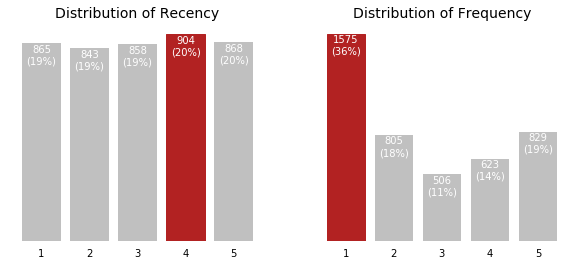

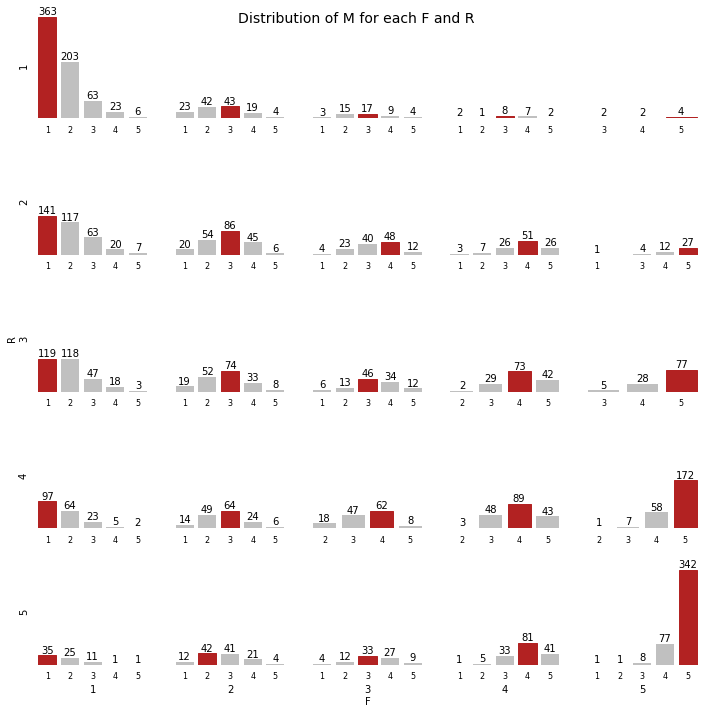

In [31]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
rfm.to_csv('rfm.csv',index=False)

In [33]:
abc = pd.read_csv('rfm.csv')

In [34]:
abc

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,hibernating
1,12347.0,2,6,3598.21,5,5,5,555,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating
5,12352.0,36,8,2506.04,3,5,5,355,loyal customers
6,12353.0,204,1,89.00,1,1,1,111,hibernating
7,12354.0,232,1,1079.40,1,1,4,114,hibernating
8,12355.0,214,1,459.40,1,1,2,112,hibernating
9,12356.0,23,3,2811.43,4,3,5,435,potential loyalists


In [35]:
labels =abc['Segment'].value_counts().keys()
counts = abc['Segment'].value_counts()

In [36]:
abc['Segment'].value_counts().keys()

Index(['hibernating', 'loyal customers', 'champions', 'potential loyalists',
       'about to sleep', 'at risk', 'promising', 'need attention',
       'new customers', 'can't loose'],
      dtype='object')

In [37]:
x=abc['Segment'].value_counts()

In [38]:
x = pd.DataFrame(x.values)

In [39]:
x.values

array([[1348],
       [ 677],
       [ 590],
       [ 497],
       [ 491],
       [ 308],
       [ 191],
       [ 111],
       [  73],
       [  52]], dtype=int64)

In [40]:
abc['Segment'].value_counts()

hibernating            1348
loyal customers         677
champions               590
potential loyalists     497
about to sleep          491
at risk                 308
promising               191
need attention          111
new customers            73
can't loose              52
Name: Segment, dtype: int64

In [41]:
rfm['Counts'] = rfm.groupby(['Segment'])['CustomerID'].transform('count')

In [42]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Counts
0,12346.0,326,1,77183.60,1,1,5,115,hibernating,1348
1,12347.0,2,6,3598.21,5,5,5,555,champions,590
2,12348.0,75,4,1797.24,2,4,4,244,at risk,308
3,12349.0,19,1,1757.55,4,1,4,414,promising,191
4,12350.0,310,1,334.40,1,1,2,112,hibernating,1348


In [43]:
rfm['Counts'].head().values

array([1348,  590,  308,  191, 1348], dtype=int64)